In [1]:
!pip install --upgrade albumentations
!pip install --upgrade torch_lr_finder
# !nvidia-smi

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.3)
Requirement already up-to-date: torch_lr_finder in /usr/local/lib/python3.7/dist-packages (0.2.1)


In [2]:
import torch
import torchvision
import cv2
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
import time
%matplotlib inline

conv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

torch.backends.cudnn.benchmark = True

In [4]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [5]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [6]:
# calculate mean and standard deviation

mean = np.mean(train_set.data, axis=(0,1,2))


sdev = np.std(train_set.data, axis=(0, 1, 2))


In [7]:
mean = mean/255
sdev = sdev/255

In [8]:
SEED = 101
BATCH = 512

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [9]:
# dataset= dsets.CIFAR10(root='./cifar10/data/', transform=transform, train= True, download=True)
# test_set= dsets.CIFAR10(root="./cifar10/data/", transform=transform, train= False)

def ZCA_whitening(X):
    X= X.reshape((-1, np.product(X.shape[1:])))
    X_centered= X - np.mean(X, axis= 0)
    Sigma= np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    U, Lambda, _= np.linalg.svd(Sigma)
    W= np.dot(U, np.dot(np.diag(1.0/np.sqrt(Lambda + 1e-5)), U.T))
    
    X_ZCA= np.dot(X_centered, W.T)
    X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
    return X_ZCA_rescaled

# dataset_zca= ZCA_whitening(dataset.train_data)
# test_set_zca= ZCA_whitening(test_set.test_data)

# dataset_zca= torch.tensor(dataset_zca.reshape(-1,32,32,3))
# test_set_zca= torch.tensor(test_set_zca.reshape(-1,32,32,3))

# torch.Tensor(dataset.train_data)
# torch.Tensor(test_set.test_data)

In [10]:
# class GaussNoise():
#     def __init__(self, mean , sdev):
#         self.mean = mean
#         self.sdev = sdev
    
#     def __call__(self, tensor=None, size=None):
#         if tensor:
#             val= torch.rand(tensor.size(), dtype=tensor.dtype) * self.sdev + self.mean

#             return val
#         else:
#             return np.random.rand(size) * self.sdev + self.mean

In [11]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [12]:
# noise = GaussNoise(mean=mean, sdev=sdev)
# noise_to_add = noise(size=mean.shape[0])
lr_epochs = []
# noise(size=1)[0], noise_to_add

In [13]:
def apply_ricap(*, batch, beta=0.3):

    input, target = batch

    I_x, I_y = input.size()[2:]

    w = int(np.round(I_x * np.random.beta(beta, beta)))
    h = int(np.round(I_y * np.random.beta(beta, beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]

    cropped_images = {}
    c_ = {}
    W_ = {}

    for k in range(4):
        idx = torch.randperm(input.size(0))
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
        c_[k] = target[idx].cuda()
        W_[k] = w_[k] * h_[k] / (I_x * I_y)

    patched_images = torch.cat(
        (torch.cat((cropped_images[0], cropped_images[1]), 2),
         torch.cat((cropped_images[2], cropped_images[3]), 2)),
        3)

    patched_images = patched_images.cuda()
    
    return patched_images

In [14]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1,
                     criterion=None,
                     test=False, test_loader=None,
                     scheduler=None,
                     grad_clip=None,
                     l1=False, lambda_1=0.001,
                     noise_level=0.1,
                     ricap_apply=False,
                     ricap_beta=0.3,
                     ricap_prob=0.1):
    if not model:
        raise NotImplementedError("\nNo model provided")
    if not train_loader:
        raise NotImplementedError("\nTrain Loader not provided")
    if not optimizer:
        raise NotImplementedError("\nOptimizer not provided")
    if not device:
        raise ValueError("\nno device provided, kindly provide CPU or Cuda to use")
    if ricap_apply:
        print(f"\n\nRICAP has been set to True with probability: {ricap_prob} and Beta value: {ricap_beta}")
    
    # if `criterion` is not given use CrossEntropy Loss as default
    if not criterion:
        criterion = nn.CrossEntropyLoss()
    
    model.train()  # set the train mode

    scaler = torch.cuda.amp.GradScaler()  # create grad scaler
    
    # iterate over for `epochs` epochs and keep storing valuable info
    for epoch in range(epochs):
        print(f"\n\n\nepoch num ===================================== {epoch + 1}")
        correct = processed = train_loss = regularization_loss = 0

        pbar = tqdm(train_loader)
        ricap_count = 0

        if scheduler:
            last_lr = scheduler.get_last_lr()
            lr_epochs.append((epoch + 1, last_lr))
            print(f"LR at epoch {epoch + 1} start: -->", last_lr, end="\n\n")

        if l1:
            for param in model.parameters():
                regularization_loss += torch.sum(abs(param))

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)  # move data to `device`

            optimizer.zero_grad()  # zero out the gradients to avoid accumulating them over loops

            # apply RICAP is flag is True and `ricap_prob` greater than random number
            if ricap_apply and (ricap_prob > np.random.random()):
                # print(f"Applying RICAP")
                ricap_count += 1
                data = apply_ricap(batch=(data, target), beta=ricap_beta)

            with torch.cuda.amp.autocast():
              output = model(data)  # get model's predictions
              
              loss = criterion(output, target) + lambda_1 * regularization_loss
            #   loss += noise(tensor=loss)

            train_loss += loss.item()

            scaler.scale(loss).backward()
            # loss.backward() # to perform backpropagation and calculate the gradients

            # if gradient clipping is to be used
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # optimizer.step() # take 1 step for the optimizer and update the weights

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            correct += pred.eq(target.view_as(
                pred)).sum().item()  # compare and see how many predictions are coorect and then add up the count

            processed += len(data)  # total processed data size

            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

        acc = 100 * correct / processed

        train_losses.append(train_loss)

        train_accuracy.append(acc)

        pbar.set_description(desc=f'loss={loss.item()} batch_id={batch_idx}')

        total_batch_iters = len(train_loader)
        ricap_perc = ricap_count/total_batch_iters
        print(f"\n\nRicap applied: {ricap_perc * 100:.2f} percent of total batch iterations")

        train_loss /= len(train_loader.dataset)
        print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct, len(train_loader.dataset),
                                                                        correct * 100 / len(train_loader.dataset)))

        if test:  # moving to evaluation
            model.eval()  # set the correct mode
            correct = test_loss = 0

            with torch.no_grad():  # to disable gradient calculation with no_grad context
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)

                    output = model(data)

                    test_loss += criterion(output, target).sum().item()  # sum up batch loss

                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

                    correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            test_accuracy.append(100. * correct / len(test_loader.dataset))

            print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))


In [15]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [16]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [17]:
# # transforms

# train_transforms = A.Compose([
#                             A.augmentations.transforms.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT,
#                                                                        p=0.5,value=mean),
#                             A.RandomCrop(32, 32, p=1),
#                             A.HorizontalFlip(p=0.5),
#                             A.CoarseDropout(max_holes=1,
#                                             p=0.2,
#                                             max_height=8,
#                                             max_width=8,
#                                             min_height=8,
#                                             min_width=8,
#                                             fill_value= mean),
                              
#                             A.Normalize(mean=mean, std=sdev),
#                             ToTensor()
#                             ])

# test_transforms = A.Compose([A.HorizontalFlip(p=0.3),
#                              A.Normalize(mean=mean, std=sdev),
#                             ToTensor()
#                             ])


train_transforms = A.Compose([     
                    A.Sequential([
                    A.CropAndPad(px=4, keep_size=False),
                    A.RandomCrop(32,32)]),
                    A.HorizontalFlip(p=0.7),
                    A.CoarseDropout(p=0.7, max_holes = 1, max_height=8, max_width=8, min_height=8,
                                    min_width=8, fill_value=(0.4914, 0.4822, 0.4465)),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                    ToTensorV2(),
                    ])

test_transforms = A.Compose([
                  A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                  ToTensorV2(),
                ])

In [18]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

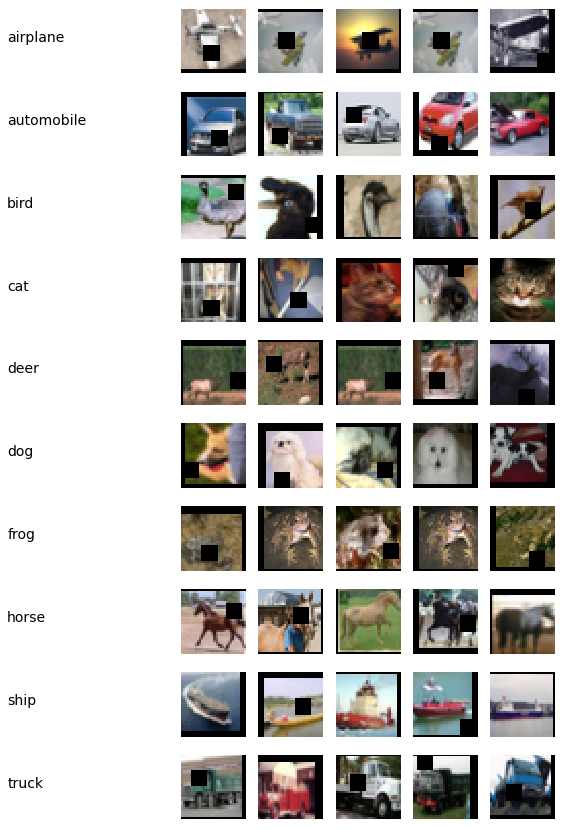

In [19]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [20]:
class GBN(torch.nn.Module):
    """
    Ghost Batch Normalization
    """

    def __init__(self, input_dim, virtual_batch_size=128, momentum=0.01):
        super(GBN, self).__init__()

        self.input_dim = input_dim
        self.virtual_batch_size = virtual_batch_size
        self.bn = nn.BatchNorm2d(self.input_dim, momentum=momentum)

    def forward(self, x):
        chunks = x.chunk(int(np.ceil(x.shape[0] / self.virtual_batch_size)), 0)
        res = [self.bn(x_) for x_ in chunks]

        return torch.cat(res, dim=0)

In [21]:
# def get_conv_block(in_channels=3, out_channels=64, max_pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)]
    
#     if max_pool:
#         layers.append(nn.MaxPool2d(2))

#     layers.extend([GBN(out_channels, momentum=0.1),
#                    nn.ReLU(inplace=True)])

#     return nn.Sequential(*layers)

"""Pre-activated approach, try with this now"""
def get_conv_block(in_channels=3, out_channels=64, max_pool=False):
    layers = [GBN(in_channels, virtual_batch_size=128, momentum=0.1),
                   nn.ReLU(inplace=True)]
    
    if max_pool:
        layers.append(nn.MaxPool2d(2))

    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))

    return nn.Sequential(*layers)

class CustomResNet(nn.Module):
    def __init__(self, in_planes, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        self.conv1 = get_conv_block(in_channels = in_planes, out_channels = 64)

        self.conv2 = get_conv_block(in_channels = 64, out_channels = 128, max_pool=True)

        self.res1 = nn.Sequential(get_conv_block(in_channels=128, out_channels=128), get_conv_block(in_channels=128, out_channels=128))
        
        self.conv3 = get_conv_block(128, 256, max_pool=True)

        self.conv4 = get_conv_block(256, 512, max_pool=True)
        
        self.res2 = nn.Sequential(get_conv_block(512, 512), get_conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes, bias=False))
        # self.extra_1 = nn.Sequential(
        #     nn.Conv2d(64, 128, 1, stride=2),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 256, 3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2)
        # )
        
    def forward(self, x):
        x1 = out = self.conv1(x)
        out = self.conv2(out)
        out = out + self.res1(out)
        out = self.conv3(out) #+ self.extra_1(x1)
        out = self.conv4(out)
        out = out + self.res2(out)
        out = self.classifier(out)
        # out = out.view(-1, self.num_classes)
        # out = F.softmax(out, dim=-1)
        return out

In [30]:
model = CustomResNet(3, 10).to(device)

criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)
# criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
               GBN-2            [-1, 3, 32, 32]               0
              ReLU-3            [-1, 3, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           1,728
       BatchNorm2d-5           [-1, 64, 32, 32]             128
               GBN-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,728
      BatchNorm2d-10          [-1, 128, 16, 16]             256
              GBN-11          [-1, 128, 16, 16]               0
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

In [31]:
# from torch_lr_finder import LRFinder

# # optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum=0.9, nesterov=True, weight_decay=1e-5)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [32]:
model = CustomResNet(3, 10).to(device)
# 0.02 with decay 1e-5 -> seems promising & 0.05 with 2e-5

max_lr = 1.8e-2
# 0.05, -> 
# 1) 2.49e-1, -> can take more 2) 2.91e-1 3) 3.1e-1,-> 84% & 82% can take more 4) 4.3e-1 -> can take more perhaps, try
# 5) 4.9e-1,  6) 5.9e-1 with opt lr 2.49e-2, 7) 5.1e-1 with 1.49e-2

optimizer = optim.SGD(model.parameters(), momentum=0.9, lr = max_lr/10, nesterov=True, weight_decay=0.000125) # ["0.000125", "0.00025", "0.0005"]
# 2.49e-2, -> 3.4e-2, 

# optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                max_lr=max_lr,
                                                pct_start=0.2,
                                                anneal_strategy='linear',
                                                verbose=False,
                                                epochs=24,
                                                cycle_momentum=False,
                                                steps_per_epoch=len(train_loader))



train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
lr_epochs = []

start = time.perf_counter()

train_eval_model(model=model,
                 train_loader=train_loader,
                 optimizer = optimizer,
                 criterion=criterion,
                 device=device,
                 epochs=24,
                 test=True,
                 test_loader=test_loader,
                 scheduler=scheduler,
                 grad_clip=None,
                 noise_level=0,
                 ricap_apply=False)
                #  ricap_prob=0.05,
                #  ricap_beta=0.32)

end = time.perf_counter()

print(f"\n\nTime taken: {(end - start)//60} minutes and {int((end - start)%60)} seconds")

  0%|          | 0/98 [00:00<?, ?it/s]




epoch num ===================================== 1
LR at epoch 1 start: --> [0.0007199999999999999]



100%|██████████| 98/98 [00:09<00:00, 10.05it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 16326/50000 (32.6520%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0033, accuracy: 4777/10000 (47.77000%)




epoch num ===================================== 2
LR at epoch 2 start: --> [0.004327669365146996]



100%|██████████| 98/98 [00:09<00:00, 10.24it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 13401/50000 (26.8020%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0037, accuracy: 3838/10000 (38.38000%)




epoch num ===================================== 3
LR at epoch 3 start: --> [0.007935338730293992]



100%|██████████| 98/98 [00:09<00:00, 10.81it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 20269/50000 (40.5380%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0034, accuracy: 4527/10000 (45.27000%)




epoch num ===================================== 4
LR at epoch 4 start: --> [0.011543008095440987]



100%|██████████| 98/98 [00:09<00:00, 10.68it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 24175/50000 (48.3500%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0030, accuracy: 5656/10000 (56.56000%)




epoch num ===================================== 5
LR at epoch 5 start: --> [0.015150677460587984]



100%|██████████| 98/98 [00:09<00:00, 10.66it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 25853/50000 (51.7060%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0029, accuracy: 5922/10000 (59.22000%)




epoch num ===================================== 6
LR at epoch 6 start: --> [0.01780293446173469]



100%|██████████| 98/98 [00:09<00:00, 10.54it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 29799/50000 (59.5980%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0026, accuracy: 6596/10000 (65.96000%)




epoch num ===================================== 7
LR at epoch 7 start: --> [0.016865438211734692]



100%|██████████| 98/98 [00:09<00:00, 10.08it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 32433/50000 (64.8660%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0024, accuracy: 6998/10000 (69.98000%)




epoch num ===================================== 8
LR at epoch 8 start: --> [0.015927941961734693]



100%|██████████| 98/98 [00:09<00:00, 10.04it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 34367/50000 (68.7340%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0024, accuracy: 7173/10000 (71.73000%)




epoch num ===================================== 9
LR at epoch 9 start: --> [0.014990445711734694]



100%|██████████| 98/98 [00:09<00:00, 10.74it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 35997/50000 (71.9940%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 7548/10000 (75.48000%)




epoch num ===================================== 10
LR at epoch 10 start: --> [0.014052949461734694]



100%|██████████| 98/98 [00:09<00:00, 10.59it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 37167/50000 (74.3340%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 7593/10000 (75.93000%)




epoch num ===================================== 11
LR at epoch 11 start: --> [0.013115453211734693]



100%|██████████| 98/98 [00:09<00:00, 10.51it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 38328/50000 (76.6560%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 7583/10000 (75.83000%)




epoch num ===================================== 12
LR at epoch 12 start: --> [0.012177956961734694]



100%|██████████| 98/98 [00:09<00:00, 10.57it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 39030/50000 (78.0600%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 7914/10000 (79.14000%)




epoch num ===================================== 13
LR at epoch 13 start: --> [0.011240460711734693]



100%|██████████| 98/98 [00:09<00:00, 10.15it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 40024/50000 (80.0480%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 7516/10000 (75.16000%)




epoch num ===================================== 14
LR at epoch 14 start: --> [0.010302964461734693]



100%|██████████| 98/98 [00:09<00:00, 10.15it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 40552/50000 (81.1040%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8105/10000 (81.05000%)




epoch num ===================================== 15
LR at epoch 15 start: --> [0.009365468211734694]



100%|██████████| 98/98 [00:09<00:00, 10.33it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 41345/50000 (82.6900%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8138/10000 (81.38000%)




epoch num ===================================== 16
LR at epoch 16 start: --> [0.008427971961734693]



100%|██████████| 98/98 [00:09<00:00, 10.72it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 41806/50000 (83.6120%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8200/10000 (82.00000%)




epoch num ===================================== 17
LR at epoch 17 start: --> [0.007490475711734694]



100%|██████████| 98/98 [00:09<00:00, 10.73it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 42211/50000 (84.4220%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8251/10000 (82.51000%)




epoch num ===================================== 18
LR at epoch 18 start: --> [0.006552979461734694]



100%|██████████| 98/98 [00:09<00:00, 10.74it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 42759/50000 (85.5180%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8236/10000 (82.36000%)




epoch num ===================================== 19
LR at epoch 19 start: --> [0.005615483211734693]



100%|██████████| 98/98 [00:09<00:00, 10.42it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 43007/50000 (86.0140%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8331/10000 (83.31000%)




epoch num ===================================== 20
LR at epoch 20 start: --> [0.004677986961734694]



100%|██████████| 98/98 [00:09<00:00, 10.06it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 43445/50000 (86.8900%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8316/10000 (83.16000%)




epoch num ===================================== 21
LR at epoch 21 start: --> [0.0037404907117346946]



100%|██████████| 98/98 [00:09<00:00, 10.07it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 43677/50000 (87.3540%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8384/10000 (83.84000%)




epoch num ===================================== 22
LR at epoch 22 start: --> [0.0028029944617346935]



100%|██████████| 98/98 [00:09<00:00, 10.71it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 44037/50000 (88.0740%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8411/10000 (84.11000%)




epoch num ===================================== 23
LR at epoch 23 start: --> [0.0018654982117346924]



100%|██████████| 98/98 [00:09<00:00, 10.61it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 44271/50000 (88.5420%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8437/10000 (84.37000%)




epoch num ===================================== 24
LR at epoch 24 start: --> [0.0009280019617346966]



100%|██████████| 98/98 [00:09<00:00, 10.85it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 44394/50000 (88.7880%)



	Test metrics: average loss: 0.0019, accuracy: 8471/10000 (84.71000%)



Time taken: 4.0 minutes and 5 seconds


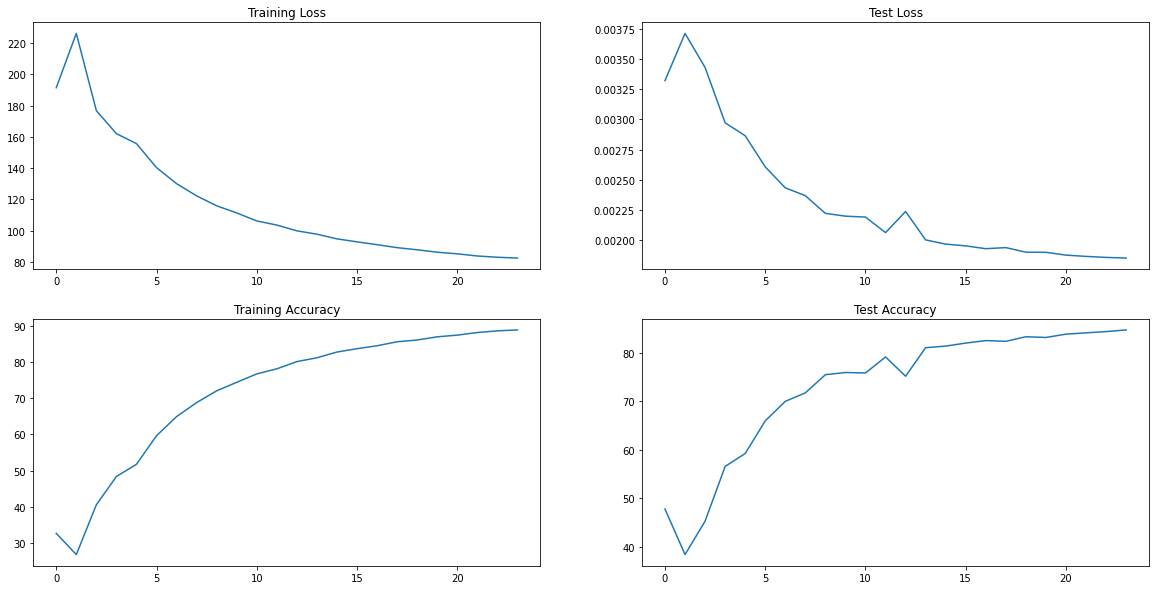

In [33]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)    

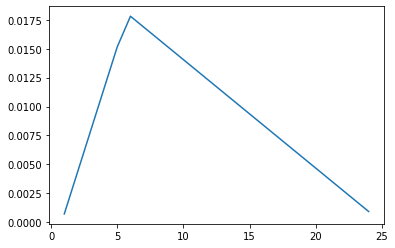

In [34]:
plt.plot(*zip(*lr_epochs))